# Building an ePSF
Using https://photutils.readthedocs.io/en/stable/epsf.html

In [54]:
from astropy.io import fits
import numpy as np
from MTLib import PATH

with fits.open(PATH.DATAMAPS.value + 'HST/source13/source13_F160w.fits') as hdul:
    hdu = hdul[0]
    data: np.ndarray = hdu.data

### Visualize the data

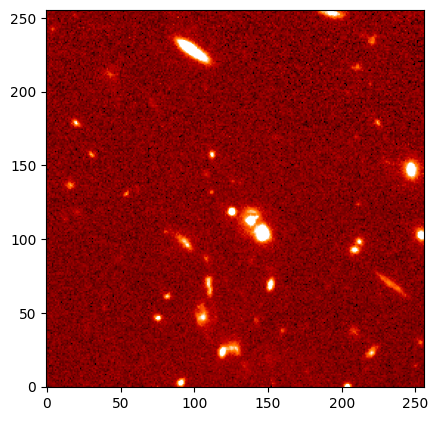

In [55]:
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5),dpi=100)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='gist_heat')

### Find peaks in the data-map

In [56]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data, threshold=0.15)  
print(type(peaks_tbl))
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl)  

<class 'astropy.table.table.Table'>
x_peak y_peak peak_value
------ ------ ----------
   204      0 0.40411592
    91      2 0.43537554
   220     23 0.16023454
   119     24 0.28425762
   128     26 0.15764105
    76     46 0.27772132
   106     47 0.20634148
   152     69 0.29660454
   209     93 0.26640537
    95     96 0.17831948
   ...    ...        ...
   137    112 0.40135729
   139    113 0.53896719
   142    115 0.17463818
   125    118 0.77315378
   247    147 0.48625714
   112    157  0.2444275
    20    178 0.20262328
   105    222 0.24233444
    98    229 0.79402161
   195    252 0.22755279
   192    253 0.34758234
Length = 24 rows


### Extract cutouts around the peaks
We plan to extract 10 x 10 pixel cutouts of our selected stars, so let’s explicitly exclude stars that are too close to the image boundaries (because they cannot be extracted):

In [57]:
size = 15
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))

Let us also exclude peaks where the seperation is shorter than the cutout size

In [75]:
N = len(mask)
# Go through all the peaks
for i in range(N):
    # if the peak is not within the mask go on to next peak
    if not mask[i]:
        continue
    # Go through the remaining peaks
    for j in range(i+1,N):
        # if the peak is not within the mask, go on to the next peak
        if not mask[j]:
            continue
        dist = np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
        if dist < size:
            print(f'{i}({x[i]},{y[i]}) is too close to {j}({x[j]},{y[j]}) | {dist:.3f}')
            mask[i], mask[j] = False
    


3(119,24) is too close to 4(128,26) | 9.220
8(209,93) is too close to 10(212,98) | 5.831
12(146,103) is too close to 13(137,112) | 12.728
12(146,103) is too close to 14(139,113) | 12.207
12(146,103) is too close to 15(142,115) | 12.649
13(137,112) is too close to 14(139,113) | 2.236
13(137,112) is too close to 15(142,115) | 5.831
13(137,112) is too close to 16(125,118) | 13.416
14(139,113) is too close to 15(142,115) | 3.606
14(139,113) is too close to 16(125,118) | 14.866
20(105,222) is too close to 21(98,229) | 9.899


Let's quickly visualize the areas

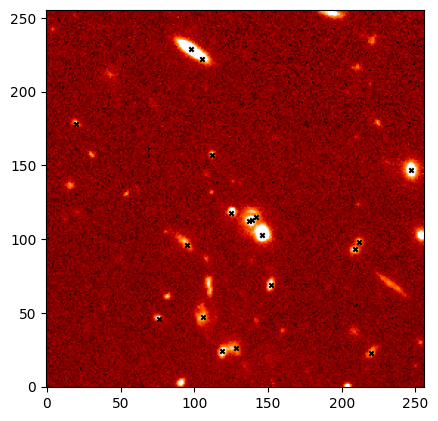

In [58]:
plt.figure(figsize=(5,5),dpi=100)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='gist_heat')

for xp, yp in zip(x[mask],y[mask]):
    plt.scatter(xp,yp,s=10,c='k',marker='x')

plt.show()

Now let’s create the table of good star positions:

In [59]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]  

The extract_stars() method requires the input data as an NDData object. An NDData object is easy to create from our data array:

In [60]:
from astropy.nddata import NDData
nddata = NDData(data=data) 

Let’s extract the 10 x 10 pixel cutouts of our selected stars:

In [61]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=size)  

The function returns a EPSFStars object containing the cutouts of our selected stars. Lets see some of them

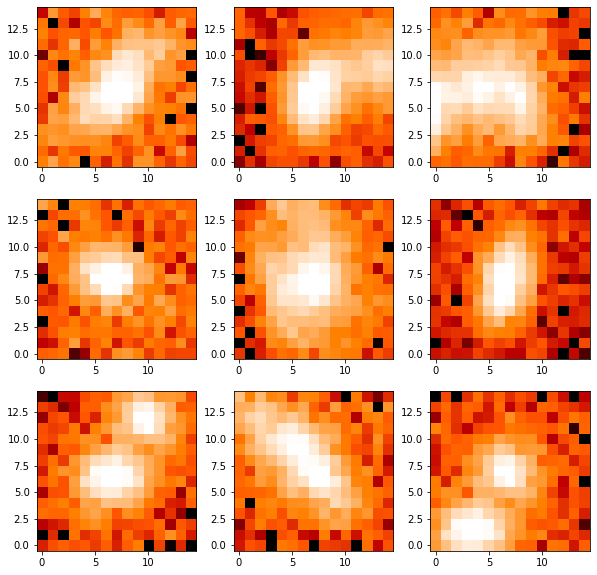

In [62]:

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=95.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='gist_heat')

### Build the ePSF

In [63]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)  

### The constructed ePSF

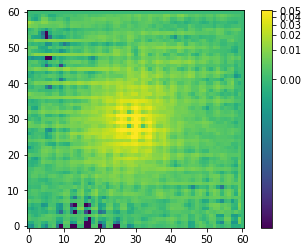

In [64]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()